*Граф* - абстрктная математическая конструкция, которая применятся для моделирования реальной задачи путём её разделения на множество связанных узлов. Каждый такой узел называется *вершиной*, а каждое соединение - *ребром*.

In [1]:
from __future__ import annotations
from dataclasses import dataclass
from typing import TypeVar, Generic, List, Optional
%pylab inline
figsize(15, 8)
import networkx as nx

def draw_nx(graph):
    G=nx.Graph()
    G.add_nodes_from(graph._vertices)
    edges_from = []
    for u in range(graph.vertex_count):
        for v in graph.neighbors_for_index(u):
             edges_from.append((graph.vertex_at(u), v))
    G.add_edges_from(edges_from)
    pos = nx.spring_layout(G) # позиции для всех узлов
    nx.draw_networkx_nodes(G,pos,
        node_size=700,
        alpha= 0.5,
        node_color= 'pink',)
    nx.draw_networkx_labels(G,pos,
        font_size=16,
        font_family='sans-serif')
    edges = [(u,v) for (u,v,d) in G.edges(data=True)]
    nx.draw_networkx_edges(G, pos, 
        edgelist=edges,
        font_size=16, 
        alpha= 0.3,
        with_labels = False)
    show()

def draw_weighted_nx(weightedGraph, wp:WeightedPath=None):
    G=nx.Graph()
    G.add_nodes_from(weightedGraph._vertices)
    weighted_edges_from = []
    for u in range(weightedGraph.vertex_count):
        for v, w in weightedGraph.neighbors_for_index_with_weights(u):
             weighted_edges_from.append((weightedGraph.vertex_at(u), v, w))
    G.add_weighted_edges_from(weighted_edges_from)
    pos = nx.spring_layout(G) # позиции для всех узлов
    nx.draw_networkx_nodes(G,pos,
        node_size=700,
        alpha= 0.5,
        node_color='pink',)
    nx.draw_networkx_labels(G,pos,
        font_size=16,
        font_family='sans-serif')
    # вершины
    edges = [(u,v) for (u,v,d) in G.edges(data=True)]
    nx.draw_networkx_edges(G, pos, 
        edgelist=edges,
        font_size=16, 
        alpha= 0.3,
        with_labels = False)
    # метки вершин (для взвешенного графа)
    edge_labels=dict([((u,v,), d['weight'])
                 for u,v,d in G.edges(data=True)])
    nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
    if wp: # WeightedPath
        red_edges = [
            (weightedGraph.vertex_at(edge.u),
            weightedGraph.vertex_at(edge.v))
            for edge in wp]
        nx.draw_networkx_edges(G, pos,
            edgelist = red_edges,
            edge_color='r',
            arrows = True)
    show()

Populating the interactive namespace from numpy and matplotlib


In [2]:
@dataclass
class Edge:
    u: int # the "from" vertex
    v: int # the "to" vertex

    def reversed(self) -> Edge:
        return Edge(self.v, self.u)

    def __str__(self) -> str:
        return f"{self.u} --> {self.v}"

In [3]:
print(Edge('Moscow', 'USA'))
print(Edge('Moscow', 'USA').reversed())

Moscow --> USA
USA --> Moscow


In [4]:
V = TypeVar('V') # type of the vertices in the graph


class Graph(Generic[V]):
    def __init__(self, vertices: List[V] = []):
        self._vertices: List[V] = vertices
        self._edges: List[List[Edge]] = [[] for _ in vertices]

    @property
    def vertex_count(self):
        """Количество вершин"""
        return len(self._vertices)

    @property
    def edge_count(self):
        """Количество рёбер"""
        return sum(map(len, self._edges))
    
    def add_vertex(self, vertex: V) -> int:
        """Добавляет вершину к графу и Возвращает ее индекс"""
        self._vertices.append(vertex)
        self._edges.append([]) # пустой список для рёбер
        return self.vertex_count - 1

    # (convenience method)
    def add_edge(self, edge: Edge) -> None:
        """Это неориентированный граф, поэтому мы всегда добавляем ребра в обоих направлениях"""
        self._edges[edge.u].append(edge)
        self._edges[edge.v].append(edge.reversed())

    # (convenience method)
    def add_edge_by_indices(self, u, v):
        """Добавляет ребро с помощью индексов вершин"""
        edge: Edge = Edge(u, v)
        self.add_edge(edge)

    # (convenience method)
    def add_edge_by_vertices(self, first: V, second: V):
        """Добавляет ребро, просмотрев индексы вершин"""
        u: int = self.index_of(first)
        v: int = self.index_of(second)
        self.add_edge_by_indices(u, v)
    
    # (convenience method)
    def remove_edge_by_indices(self, u, v):
        """Удаляет ребро, с помощью индексов вершин"""
        self._edges[u] = [edge for edge in self._edges[u] if edge.v != v]
        self._edges[v] = [edge for edge in self._edges[v] if edge.v != u]
    
    # (convenience method)
    def remove_edge_by_vertices(self, first: V, second: V):
        """Удаляет ребро, просмотрев индексы вершин"""
        u: int = self.index_of(first)
        v: int = self.index_of(second)
        self.remove_edge_by_indices(u, v)
        
    def vertex_at(self, index) -> V:
        """Возвращает вершину по определенному индексу"""
        return self._vertices[index]

    def index_of(self, vertex: V):
        """Возвращает индекс вершины в графе"""
        return self._vertices.index(vertex)

    def neighbors_for_index(self, index) -> List[V]:
        """Возвращает все соседние вершины, связанные с данной вершиной по некоторому индексу"""
        return list(map(self.vertex_at, [e.v for e in self._edges[index]]))

    # (convenience method)
    def neighbors_for_vertex(self, vertex: V) -> List[V]:
        """Поиск индекса вершины; и поиск ее соседей"""
        return self.neighbors_for_index(self.index_of(vertex))

    def edges_for_index(self, index) -> List[Edge]:
        """Возвращает все ребра, связанные с вершиной по некоторому индексу"""
        return self._edges[index]

    # (convenience method)
    def edges_for_vertex(self, vertex: V) -> List[Edge]:
        """Поиск индекса вершины; Возвращает её рёбра"""
        return self.edges_for_index(self.index_of(vertex))
    
    def __str__(self) -> str:
        return "\n".join(
            f"{self.vertex_at(i):13} -> {self.neighbors_for_index(i)}"
            for i in range(self.vertex_count)
        )

Seattle       -> ['Chicago', 'San Francisco']
San Francisco -> ['Seattle', 'Riverside', 'Los Angeles']
Los Angeles   -> ['San Francisco', 'Riverside', 'Phoenix']
Riverside     -> ['San Francisco', 'Los Angeles', 'Phoenix', 'Chicago']
Phoenix       -> ['Los Angeles', 'Riverside', 'Dallas', 'Houston']
Chicago       -> ['Seattle', 'Riverside', 'Dallas', 'Atlanta', 'Detroit']
Boston        -> ['Detroit', 'New York']
New York      -> ['Detroit', 'Boston', 'Philadelphia']
Atlanta       -> ['Dallas', 'Houston', 'Chicago', 'Washington', 'Miami']
Miami         -> ['Houston', 'Atlanta', 'Washington']
Dallas        -> ['Phoenix', 'Chicago', 'Atlanta', 'Houston']
Houston       -> ['Phoenix', 'Dallas', 'Atlanta', 'Miami']
Detroit       -> ['Chicago', 'Boston', 'Washington', 'New York']
Philadelphia  -> ['New York', 'Washington']
Washington    -> ['Atlanta', 'Miami', 'Detroit', 'Philadelphia']


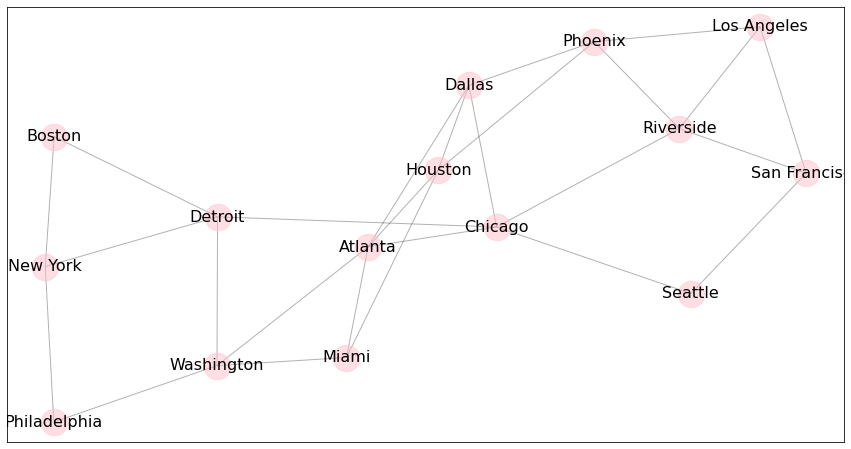

In [5]:
city_graph: Graph[str] = Graph(["Seattle", "San Francisco", "Los Angeles", "Riverside", "Phoenix", "Chicago", "Boston", "New York", "Atlanta", "Miami", "Dallas", "Houston", "Detroit", "Philadelphia", "Washington"])
city_graph.add_edge_by_vertices("Seattle", "Chicago")
city_graph.add_edge_by_vertices("Seattle", "San Francisco")
city_graph.add_edge_by_vertices("San Francisco", "Riverside")
city_graph.add_edge_by_vertices("San Francisco", "Los Angeles")
city_graph.add_edge_by_vertices("Los Angeles", "Riverside")
city_graph.add_edge_by_vertices("Los Angeles", "Phoenix")
city_graph.add_edge_by_vertices("Riverside", "Phoenix")
city_graph.add_edge_by_vertices("Riverside", "Chicago")
city_graph.add_edge_by_vertices("Phoenix", "Dallas")
city_graph.add_edge_by_vertices("Phoenix", "Houston")
city_graph.add_edge_by_vertices("Dallas", "Chicago")
city_graph.add_edge_by_vertices("Dallas", "Atlanta")
city_graph.add_edge_by_vertices("Dallas", "Houston")
city_graph.add_edge_by_vertices("Houston", "Atlanta")
city_graph.add_edge_by_vertices("Houston", "Miami")
city_graph.add_edge_by_vertices("Atlanta", "Chicago")
city_graph.add_edge_by_vertices("Atlanta", "Washington")
city_graph.add_edge_by_vertices("Atlanta", "Miami")
city_graph.add_edge_by_vertices("Miami", "Washington")
city_graph.add_edge_by_vertices("Chicago", "Detroit")
city_graph.add_edge_by_vertices("Detroit", "Boston")
city_graph.add_edge_by_vertices("Detroit", "Washington")
city_graph.add_edge_by_vertices("Detroit", "New York")
city_graph.add_edge_by_vertices("Boston", "New York")
city_graph.add_edge_by_vertices("New York", "Philadelphia")
city_graph.add_edge_by_vertices("Philadelphia", "Washington")
print(city_graph)
draw_nx(city_graph)

In [6]:
@dataclass
class WeightedEdge(Edge):
    weight: float

    def reversed(self) -> WeightedEdge:
        return WeightedEdge(self.v, self.u, self.weight)

    def __lt__(self, other: WeightedEdge):
        """Перегрузка '<', нужно для упорядочивания ребер по весу"""
        return self.weight < other.weight

    def __str__(self):
        return f"{self.u:6} --({self.weight})--> {self.v}"

In [7]:
print(WeightedEdge('Moscow', 'USA', 12))
print(WeightedEdge('Moscow', 'USA', 12).reversed())

Moscow --(12)--> USA
USA    --(12)--> Moscow


In [8]:
class WeightedGraph(Graph):
    def __init__(self, vertices: List[V] = []):
        self._vertices = vertices
        self._edges: List[List[WeightedEdge]] = [[] for _ in vertices]

    def add_edge_by_indices(self, u: int, v: int, weight):
        edge = WeightedEdge(u, v, weight)
        self.add_edge(edge)

    def add_edge_by_vertices(self, first: V, second: V, weight) -> None:
        u: int = self._vertices.index(first)
        v: int = self._vertices.index(second)
        self.add_edge_by_indices(u, v, weight)

    def neighbors_for_index_with_weights(self, index) -> List[Tuple[V, float]]:
        distance_tuples = []
        for edge in self.edges_for_index(index):
            distance_tuples.append((self.vertex_at(edge.v), edge.weight))
        return distance_tuples
    
    def __str__(self) -> str:
        return "\n".join(
             f"{self.vertex_at(i):10} -> {self.neighbors_for_index_with_weights(i)}"
            for i in range(self.vertex_count)
        )

Seattle    -> [('Chicago', 1737), ('San Francisco', 678)]
San Francisco -> [('Seattle', 678), ('Riverside', 386), ('Los Angeles', 348)]
Los Angeles -> [('San Francisco', 348), ('Riverside', 50), ('Phoenix', 357)]
Riverside  -> [('San Francisco', 386), ('Los Angeles', 50), ('Phoenix', 307), ('Chicago', 1704)]
Phoenix    -> [('Los Angeles', 357), ('Riverside', 307), ('Dallas', 887), ('Houston', 1015)]
Chicago    -> [('Seattle', 1737), ('Riverside', 1704), ('Dallas', 805), ('Atlanta', 588), ('Detroit', 238)]
Boston     -> [('Detroit', 613), ('New York', 190)]
New York   -> [('Detroit', 482), ('Boston', 190), ('Philadelphia', 81)]
Atlanta    -> [('Dallas', 721), ('Houston', 702), ('Chicago', 588), ('Washington', 543), ('Miami', 604)]
Miami      -> [('Houston', 968), ('Atlanta', 604), ('Washington', 923)]
Dallas     -> [('Phoenix', 887), ('Chicago', 805), ('Atlanta', 721), ('Houston', 225)]
Houston    -> [('Phoenix', 1015), ('Dallas', 225), ('Atlanta', 702), ('Miami', 968)]
Detroit    -> [(

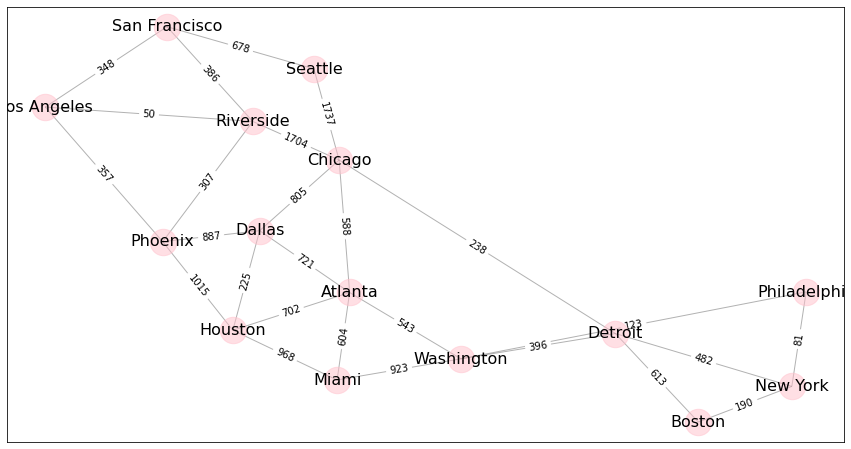

In [9]:
city_graph2 = WeightedGraph(["Seattle", "San Francisco", "Los Angeles", "Riverside", "Phoenix", "Chicago", "Boston", "New York", "Atlanta", "Miami", "Dallas", "Houston", "Detroit", "Philadelphia", "Washington"])
city_graph2.add_edge_by_vertices("Seattle", "Chicago", 1737)
city_graph2.add_edge_by_vertices("Seattle", "San Francisco", 678)
city_graph2.add_edge_by_vertices("San Francisco", "Riverside", 386)
city_graph2.add_edge_by_vertices("San Francisco", "Los Angeles", 348)
city_graph2.add_edge_by_vertices("Los Angeles", "Riverside", 50)
city_graph2.add_edge_by_vertices("Los Angeles", "Phoenix", 357)
city_graph2.add_edge_by_vertices("Riverside", "Phoenix", 307)
city_graph2.add_edge_by_vertices("Riverside", "Chicago", 1704)
city_graph2.add_edge_by_vertices("Phoenix", "Dallas", 887)
city_graph2.add_edge_by_vertices("Phoenix", "Houston", 1015)
city_graph2.add_edge_by_vertices("Dallas", "Chicago", 805)
city_graph2.add_edge_by_vertices("Dallas", "Atlanta", 721)
city_graph2.add_edge_by_vertices("Dallas", "Houston", 225)
city_graph2.add_edge_by_vertices("Houston", "Atlanta", 702)
city_graph2.add_edge_by_vertices("Houston", "Miami", 968)
city_graph2.add_edge_by_vertices("Atlanta", "Chicago", 588)
city_graph2.add_edge_by_vertices("Atlanta", "Washington", 543)
city_graph2.add_edge_by_vertices("Atlanta", "Miami", 604)
city_graph2.add_edge_by_vertices("Miami", "Washington", 923)
city_graph2.add_edge_by_vertices("Chicago", "Detroit", 238)
city_graph2.add_edge_by_vertices("Detroit", "Boston", 613)
city_graph2.add_edge_by_vertices("Detroit", "Washington", 396)
city_graph2.add_edge_by_vertices("Detroit", "New York", 482)
city_graph2.add_edge_by_vertices("Boston", "New York", 190)
city_graph2.add_edge_by_vertices("New York", "Philadelphia", 81)
city_graph2.add_edge_by_vertices("Philadelphia", "Washington", 123)
print(city_graph2)
draw_weighted_nx(city_graph2)

#### <center>Минимальное связующее дерево</center>

*Дерево* - особый вид графа, в котором между двумя вершинами существует только один путь
Это подразумевает, что в дереве нет *циклов* (такие графы называются ациклическим). Цикл можно представить как петлю: если возможно из начальной вершины пройти по всему графу, никогда не проходя повторно ни по одному из рёбер, и вернуться к начальной вершине, то в этом графе есть цикл. Любой граф, не является деревом, но может им стать, если удалиь из него некоторые рёбра.
<img src='https://user-images.githubusercontent.com/54672403/97460405-c8626580-194d-11eb-831e-e648fa30a36d.jpg' width='700px'>

*Связанный граф* - это граф, для которого существует способ добраться из любой вершины в любую другую вершину. Связанное дерево - дерево, которое соеденяет все во взвешенном графе и имеет минимальные общий вес по сравнению с другими связующими деревьями. Для каждого взвешенного графа можно найти минимальное связующее дерево. Найти минимальное связующее дерево - это тоже самое, что найти способ связать все вершины во  взвешенном графе с минимальным весом. Интуиция: "Минимальная длина кабеля, необходимого для подключения всех телефонов"

**Алгоритм Ярника** для поиска минимального связующего дерева посредством деления графа на две части: вершины в формируемом минимальном связующем дереве и вершины, ещё не входящие в минимальное связующее дерево.
1. Выбираем вершину для включения в минимальное связующее дерево
2. Находим ребро с наименьшим весом, соединяющим минимальное связующее дерево с вершинами, ещё не входящими в минимальное связующее дерево.
3. Добавляем вершину, расположенную на конце минимального ребра, к минимальному связующему дереву

In [10]:
WeightedPath = List[WeightedEdge]

from heapq import heappush, heappop
class PriorityQueue():
    def __init__(self):
        self._container = []
        
    @property
    def empty(self):
        return not self._container 
    
    def push(self, item):
        heappush(self._container, item) # добавление по приоритету
    
    def pop(self):
        return heappop(self._container) # исключение по приоритету


def total_weight(wp: WeightedPath):
    return sum([e.weight for e in wp])

In [11]:
def MinimumSpanningTree(wg: WeightedGraph, starting_vertex_index = 0):
    assert starting_vertex_index < wg.vertex_count
    result_tree = []
    priorityQueue = PriorityQueue()
    visited = [False] * wg.vertex_count
    def visit(index):
        visited[index] = True
        for edge in wg.edges_for_index(index):
            if not visited[edge.v]:
                priorityQueue.push(edge)
    visit(starting_vertex_index)
    while not priorityQueue.empty:
        edge = priorityQueue.pop()
        if visited[edge.v]:
            continue 
        result_tree.append(edge)
        visit(edge.v)
    return result_tree

def print_weighted_path(wg: WeightedGraph, wp: WeightedPath):
    for edge in wp:
        print(f'{wg.vertex_at(edge.u):13} --({edge.weight:3})--> {wg.vertex_at(edge.v)}')
    print(f'\nTotal Weight: {total_weight(wp)}')

Seattle       --(678)--> San Francisco
San Francisco --(348)--> Los Angeles
Los Angeles   --( 50)--> Riverside
Riverside     --(307)--> Phoenix
Phoenix       --(887)--> Dallas
Dallas        --(225)--> Houston
Houston       --(702)--> Atlanta
Atlanta       --(543)--> Washington
Washington    --(123)--> Philadelphia
Philadelphia  --( 81)--> New York
New York      --(190)--> Boston
Washington    --(396)--> Detroit
Detroit       --(238)--> Chicago
Atlanta       --(604)--> Miami

Total Weight: 5372


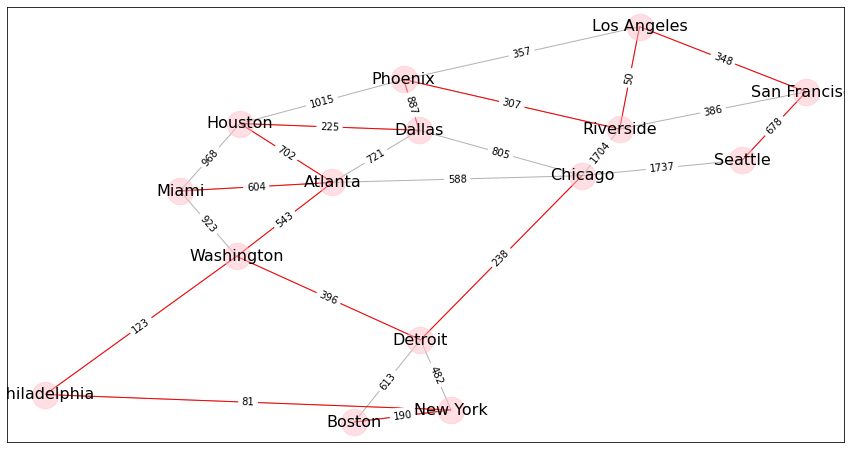

In [12]:
mst_city_graph2 = MinimumSpanningTree(city_graph2)
print_weighted_path(city_graph2, mst_city_graph2)
draw_weighted_nx(city_graph2, mst_city_graph2)

### <center>Поиск кратчайших путей во взвешенном графе </center>

**Алгоритм Дейкстры** решает задачу поиска кратчайшего пути из одгой вершины 

1. Добавляем начальную вершину в очередь с приорететом
2. Извлекаем из очереди с приоритетом вершину (всегда ближайшую)
3. Исследуем все соседние вершины, связанные с текущей. Если они ранее не были использованы или если ребро предлагает новый кратчайший путь, то для каждой из этих вершин записать расстояние от начальной вершины, указать ребро, соответствующее этому расстоянию, и добавить новую вершину в очердь с приоритетом
4. Возращаем кратчайшее расстояние до каждой вершины от начальной и путь. 

**Примечание:** алгоритм Дейкстры работает только на графе  с положительными весами. 
<br>
Для нахождения кратчайшего пути в графе, содержащем ребра с отрицательным весом, надо использовать алгоритм Беллмана-Форда

In [13]:
@dataclass
class DijkstraNode:
    vertex_index: int
    distance: float

    def __lt__(self, other: DijkstraNode):
        return self.distance < other.distance

    def __eq__(self, other: DijkstraNode):
        return self.distance == other.distance

In [14]:
def dijkstra(wg: WeightedGraph, root: V):
    """
    distances List[float] - расстояния до каждой вершины графа от вершины root
    path_dict: Dict[int, WeightedEdge] - словарь рёбер, позволяющий достич каждого узла  
    """
    starting_vertex_index = wg.index_of(root)
    distances = [None] * wg.vertex_count
    distances[starting_vertex_index] = 0 # расстояние до на начальной вершины раво 0
    path_dict: Dict[int, WeightedEdge] = {} # как добраться до каждой вершины
    priorityQueue = PriorityQueue()
    priorityQueue.push(DijkstraNode(starting_vertex_index, 0))
    
    while not priorityQueue.empty:
        u = priorityQueue.pop().vertex_index
        # старое расстояние до этой вершины
        dist_u = distances[u]
        for we in wg.edges_for_index(u):
            # старое расстояние до этой вершины
            dist_v = distances[we.v]
            # старого расстояния не существует или найденн более короткий пути
            if dist_v is None or dist_v > we.weight + dist_u:
                distances[we.v] = we.weight + dist_u
                path_dict[we.v] = we
                priorityQueue.push(DijkstraNode(we.v, we.weight + dist_u))
    return distances, path_dict

def distance_array_to_vertex_dict(wg: WeightedGraph, distances):
    distance_dict = {}
    for i in range(len(distances)):
        distance_dict[wg.vertex_at(i)] = distances[i]
    return distance_dict

def path_dict_to_path(start, end, path_dict: Dict[int, WeightedEdge]):
    """Возвращает список ребер от start до end"""
    if len(path_dict) == 0: return []
    edge_path: WeightedPath = []
    e: WeightedEdge = path_dict[end]
    edge_path.append(e)
    while e.u != start:
        e = path_dict[e.u]
        edge_path.append(e)
    return list(reversed(edge_path))

Distances from Los Angeles:
Seattle    : 1026
San Francisco : 348
Los Angeles : 0
Riverside  : 50
Phoenix    : 357
Chicago    : 1754
Boston     : 2605
New York   : 2474
Atlanta    : 1965
Miami      : 2340
Dallas     : 1244
Houston    : 1372
Detroit    : 1992
Philadelphia : 2511
Washington : 2388
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Shortest path from Los Angeles to Boston:
Los Angeles   --( 50)--> Riverside
Riverside     --(1704)--> Chicago
Chicago       --(238)--> Detroit
Detroit       --(613)--> Boston

Total Weight: 2605


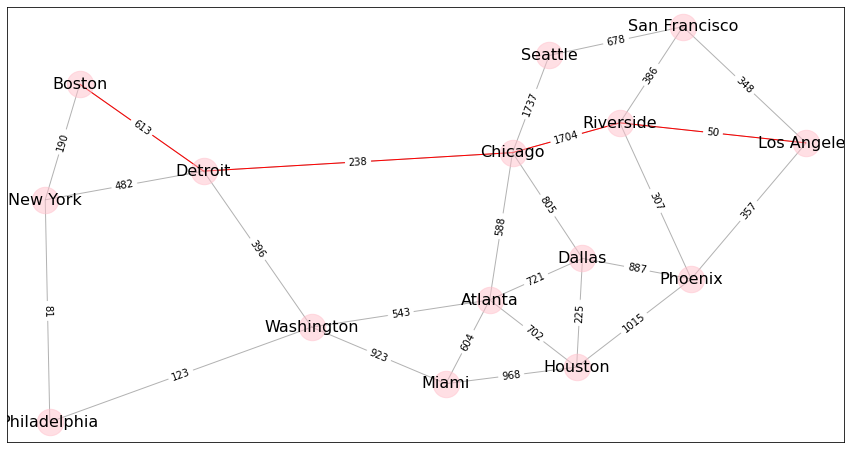

In [15]:
distances, path_dict = dijkstra(city_graph2, "Los Angeles")
name_distance = distance_array_to_vertex_dict(city_graph2, distances)
print("Distances from Los Angeles:")
for key, value in name_distance.items():
    print(f"{key:10} : {value}")

print("~"*50)
print("\nShortest path from Los Angeles to Boston:")
path = path_dict_to_path(city_graph2.index_of("Los Angeles"), city_graph2.index_of("Boston"), path_dict)
print_weighted_path(city_graph2, path)

draw_weighted_nx(city_graph2, path)